In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

In [2]:
# Import data
raw_data = pd.read_csv("../Datasets/IMDB_Dataset.csv")

# Transform all reviews to lower case only
raw_data["review"] = raw_data["review"].apply(lambda x: x.lower())

# Get all positive words
positive_words_file = open("../Datasets/positive-words.txt", "r")
positive_words = positive_words_file.read().split("\n")
positive_words = list(map(str.lower, positive_words[35:-1]))
positive_words = set(positive_words)

# Get all negative words
negative_words_file = open("../Datasets/negative-words.txt", "r")
negative_words = negative_words_file.read().split("\n")
negative_words = list(map(str.lower, negative_words[35:-1]))
negative_words = set(negative_words)

# Combine all positive and negative words into one set
sentiment_words = positive_words.union(negative_words)

In [3]:
# Create TF-IDF matrix based on sentiment words
vectorizer = TfidfVectorizer(vocabulary = sentiment_words)

tf_idf_matrix = vectorizer.fit_transform(raw_data["review"])
tf_idf_matrix = tf_idf_matrix.toarray()
tf_idf_matrix.shape

(50000, 6786)

In [4]:
# Find principal components of all dimensions (6786)
pca = PCA() # Warning: this takes like 8-9 minutes
principal_components = pca.fit(tf_idf_matrix)

Text(0, 0.5, 'Cumulative Variance Ratio')

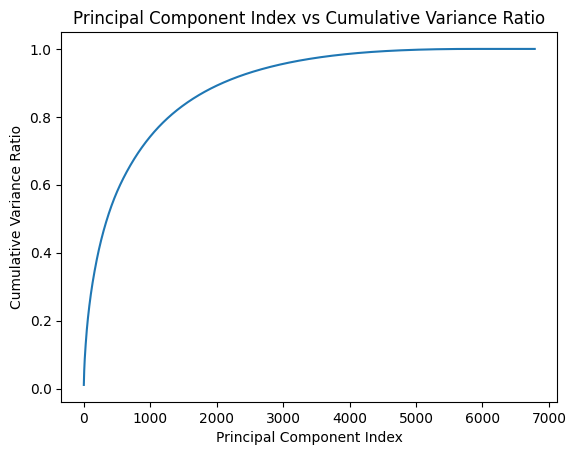

In [5]:
# Plot cumulative variance ratio vs # of principal component indices
components = list(range(1, 6787))
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(components, cumulative_variance_ratio)
plt.title("Principal Component Index vs Cumulative Variance Ratio")
plt.xlabel("Principal Component Index")
plt.ylabel("Cumulative Variance Ratio")

In [12]:
cumulative_variance_ratio[725] # 0.66 
cumulative_variance_ratio[850] # 0.70
cumulative_variance_ratio[1300] # 0,80

0.8029882440534885

In [4]:
# Choosing 850 components as that captures roughly 0.70 cumulative variance ratio
pca2 = PCA(n_components = 850)
""
transformed_features = pca2.fit_transform(tf_idf_matrix)

In [5]:
# Splitting data + converting sentiment to binary
sentiment = (raw_data['sentiment'] == 'positive').astype(int)

X_train, X_test, y_train, y_test = train_test_split(transformed_features, sentiment, train_size = 0.5, random_state = 1, shuffle = True)

In [14]:
# Very basic example of logistic regression, don't use this example use Anthony's impl
log_reg = LogisticRegression()
model = log_reg.fit(X_train, y_train)
model.score(X_test, y_test) # ratio of correct classification for logistic regression

0.85464

In [ ]:
# For saving the transformed data
df = pd.DataFrame(transformed_features)
df.to_csv("transfored_data.csv")

In [8]:
def plot_auc(roc_auc):
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [15]:
# Decision Tree Model with max depth 10, using single 50-50 split to compute error
tree_classifier = DecisionTreeClassifier(max_depth = 10)
tree_model = tree_classifier.fit(X_train, y_train)
tree_model.score(X_test, y_test)

0.75348

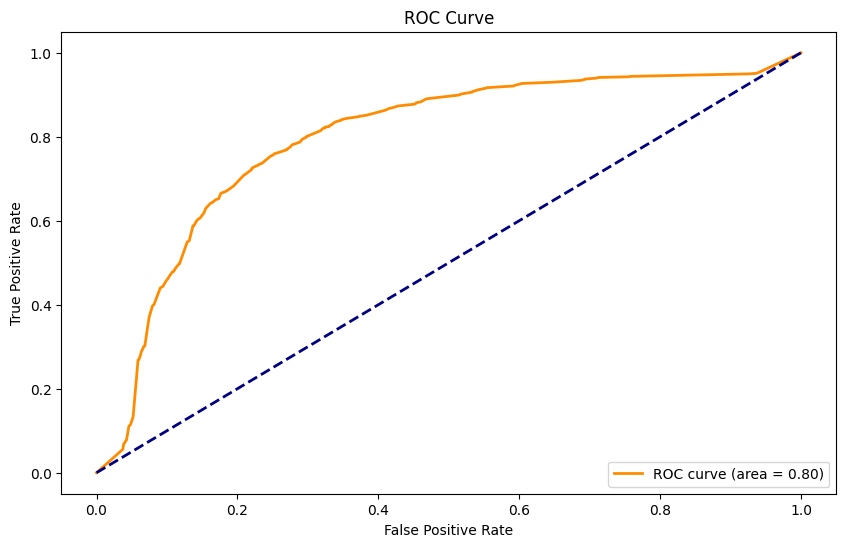

In [24]:
# ROC Curve
pred_scores = tree_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_scores)
roc_auc = auc(fpr, tpr)

plot_auc(roc_auc)

In [21]:
# Decision Tree Model with max depth 2, using 5 fold CV to compute error
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 1)
tree_classifier = DecisionTreeClassifier(max_depth = 2)

accuracy_scores = cross_val_score(tree_classifier, transformed_features, sentiment, cv = cv, scoring='accuracy')
average_accuracy = np.mean(accuracy_scores)
average_accuracy

0.7254400000000001

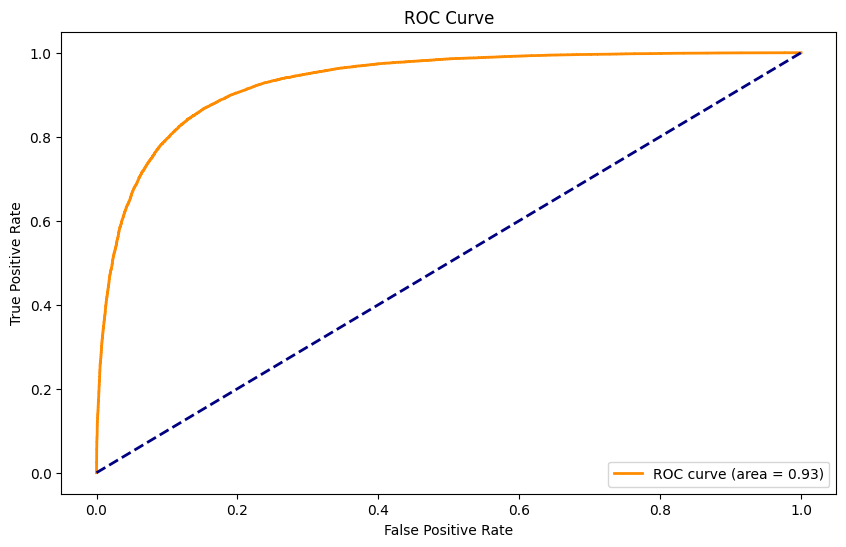

In [22]:
# ROC Curve
y_prob = cross_val_predict(model, transformed_features, sentiment, cv = cv, method = 'predict_proba')[:, 1]
fpr, tpr, thresholds = roc_curve(sentiment, y_prob)
roc_auc = auc(fpr, tpr)

plot_auc(roc_auc)

In [29]:
# Decision Tree Model with max depth 5, using 4 fold CV to compute error
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 1)
tree_classifier = DecisionTreeClassifier(max_depth = 5)

accuracy_scores = cross_val_score(tree_classifier, transformed_features, sentiment, cv = cv, scoring='accuracy')
average_accuracy = np.mean(accuracy_scores)
average_accuracy

0.7718599999999999

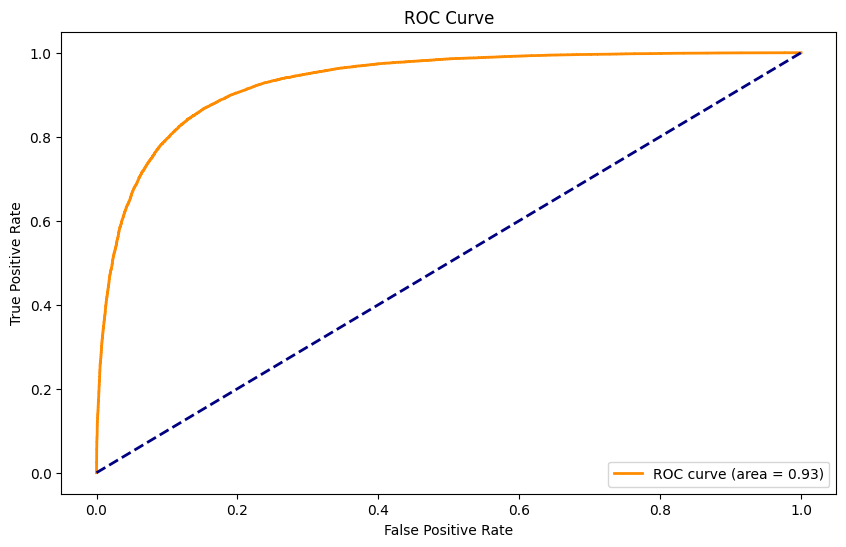

In [30]:
# ROC Curve
y_prob = cross_val_predict(model, transformed_features, sentiment, cv = cv, method = 'predict_proba')[:, 1]
fpr, tpr, thresholds = roc_curve(sentiment, y_prob)
roc_auc = auc(fpr, tpr)

plot_auc(roc_auc)

In [6]:
# Linear SVM model with regularization 1.0
linear_svm = SVC(kernel = "linear", probability = True)
linear_svm_model = linear_svm.fit(X_train, y_train)
linear_svm_model.score(X_test, y_test)

0.85448

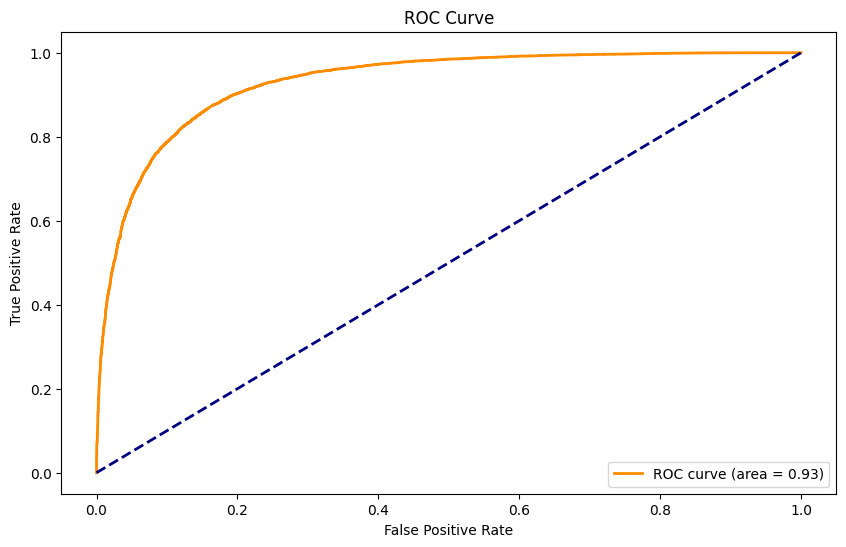

In [11]:
# ROC Curve
pred_scores = linear_svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_scores)
roc_auc = auc(fpr, tpr)

plot_auc(roc_auc)